In [1]:
import pandas as pd
from collections import OrderedDict
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Bad key "text.kerning_factor" on line 4 in
C:\Users\MARCELO\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
'''
EXTERNAL KERNEL
'''
google_colab = False
kaggle = False

'''
CUDA
'''
cuda = False

'''
DATA REPRESENTATION

1 => SINGLE READ | 2 => ADD FEATURES | 3 => WINDOW TO FEATURES
'''
DATA_REPRESENTATION = 2

'''
DOWNSAMPLE FACTOR

1 => 10hz *original rate* | 2 => 5Hz | 5 => 2Hz | 10 => 1hz
'''
DOWNSAMPLE_FACTOR = 5

'''
WINDOWS LENGHT

* needs divisor by datapoints target
* considering downsample factor = 5

1 => WINDOW DISABLED | 2 => 1 second | 4 => 2 seconds | 10 => 5 seconds | 20 => 10 seconds | 200 => 100 seconds *full flight*
'''
WINDOW_LENGHT =  1

'''
LIMITADOR

Quantity of samples in the execution of the tests.
'''
LIMITADOR = 20000

'''
LOSS FACTOR [0,1]

Ignores outliers in calculating the stats of losses in regenerated data.
'''
LOSS_FACTOR = 0.96

'''
TRAIN_SIZE [0,1]

Percentage of samples to be trained
'''
TRAIN_SIZE = 0.8

'''
OUTPUT_FILE_NAME

File with output results
'''
OUTPUT_FILE_NAME = 'output-dr_' + str(DATA_REPRESENTATION) + '-ts_' + str(TRAIN_SIZE) + '-lf_' + str.replace(str(LOSS_FACTOR), '.', '') + '-limit_' + str(LIMITADOR) + '-wl_' + str(WINDOW_LENGHT) + '.txt'

'''
PATH_OUTPUTS

'''
PATH_OUTPUTS = './outputs/'

'''
PATH_DATASET

'''
PATH_DATASET = '../../dataset/original/'

'''
FLUSH FILE

If output results file is ON
'''
FLUSH_FILE = False

In [3]:
if google_colab:
    from google.colab import drive

    drive.mount('/content/drive')
    path = '/content/drive/My Drive/ACADÊMICO/MESTRADO/DISSERTAÇÃO/CHAPTERS/5 EXPERIMENTO/dataset/data_representation_1'
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(path+'/F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(path+'/F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(path+'/F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(path+'/F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(path+'/F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(path+'/F16_DS3_fault4_fixedposition.csv', header=None),
    }
elif kaggle:
    !conda install -y gdown
    !gdown --id 1G88okIVmdcgLFlmd7rDRhHvHv98yK3UB
    !gdown --id 1fX3utfHMjwKTt7IW4D01bnm-hv88yzrJ
    !gdown --id 1yUG3R5zK2AIxtS9Q4Fk-udkKBZeYShgb
    !gdown --id 1OBRDtuqNEZ-3Z-q0helWh2xGiAxeLACH
    !gdown --id 17oDi60sWYsWHHxzj2aA9m6ARm8zQ81m_
    !gdown --id 1jKEK4s5sYJh8PHtpHeV8ABOsHjuB26RA
else:
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault4_fixedposition.csv', header=None),
    }

In [4]:
dict_ds = dict_ds_original.copy()

if dict_ds['data_ds3_normal_t1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0 or dict_ds['data_ds3_fault1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0:
    raise Exception('Needs to be ?shape? divisor')

for n, dataset_name in enumerate(dict_ds):
    dataset = dict_ds[dataset_name].to_numpy()

    downsampled = dataset[::DOWNSAMPLE_FACTOR]

    x, y = downsampled.shape

    # resample
    dict_ds[dataset_name] = pd.DataFrame(downsampled.reshape((int(x/WINDOW_LENGHT),y*WINDOW_LENGHT)))


In [5]:
# ADD COLUMNS WITH DIFF PREVIOUS VALUES

if (DATA_REPRESENTATION == 2):
    frame_size = int(1000/DOWNSAMPLE_FACTOR)

    for n, dataset_name in enumerate(dict_ds):
        dataset = dict_ds[dataset_name].to_numpy()

        dimension = dataset.shape[1]
        samples = dataset.shape[0]

        # GENERATE NEW DIMENSIONS
        dataset = np.concatenate((dataset, np.zeros((samples,dimension))), axis=1)

        for f in np.arange(0,int(samples/frame_size)):
            # OBTAIN THE FRAME FLIGHT
            frame = dataset[f*frame_size:(f+1)*frame_size, 0:dimension]

            # CALCULATE DIFFERENCE
            chunk = np.diff(frame, axis=0)

            # DONT CALCULATE THE DIFFERENCE FOR EACH FIRST TIMESTEP
            chunk = np.insert(chunk, 0, frame[0, 0:dimension], axis=0)

            # UPDATE DATASET WITH NEW FRAME INTO NEW DIMENSIONS
            dataset[f*frame_size:(f+1)*frame_size,dimension:dimension*2] = chunk

        dict_ds[dataset_name] = pd.DataFrame(dataset)



In [6]:
ss = StandardScaler()

data_ds3_t1_normal = dict_ds['data_ds3_normal_t1_original']
data_ds3_t2_normal = dict_ds['data_ds3_normal_t2_original']
data_ds3_fault1 = dict_ds['data_ds3_fault1_original']
data_ds3_fault2 = dict_ds['data_ds3_fault2_original']
data_ds3_fault3 = dict_ds['data_ds3_fault3_original']
data_ds3_fault4 = dict_ds['data_ds3_fault4_original']

# fit values
ss.partial_fit(data_ds3_t1_normal)
ss.partial_fit(data_ds3_t2_normal)
ss.partial_fit(data_ds3_fault1)
ss.partial_fit(data_ds3_fault2)
ss.partial_fit(data_ds3_fault3)
ss.partial_fit(data_ds3_fault4)

# transform values
data_ds3_t1_normal = ss.transform(data_ds3_t1_normal)
data_ds3_t2_normal = ss.transform(data_ds3_t2_normal)
data_ds3_fault1 = ss.transform(data_ds3_fault1)
data_ds3_fault2 = ss.transform(data_ds3_fault2)
data_ds3_fault3 = ss.transform(data_ds3_fault3)
data_ds3_fault4 = ss.transform(data_ds3_fault4)

# append normal labels
data_ds3_t1_normal = np.append(data_ds3_t1_normal, np.zeros((data_ds3_t1_normal.shape[0],1)), axis = 1)
data_ds3_t2_normal = np.append(data_ds3_t2_normal, np.zeros((data_ds3_t2_normal.shape[0],1)), axis = 1)

# append fault labels
def generate_fault_label(dataset, fault_label):
    labels = np.array([[fault_label]]*dataset.shape[0])

    return labels

data_ds3_fault1 = np.append(data_ds3_fault1, generate_fault_label(data_ds3_fault1, 1), axis = 1)
data_ds3_fault2 = np.append(data_ds3_fault2, generate_fault_label(data_ds3_fault2, 2), axis = 1)
data_ds3_fault3 = np.append(data_ds3_fault3, generate_fault_label(data_ds3_fault3, 3), axis = 1)
data_ds3_fault4 = np.append(data_ds3_fault4, generate_fault_label(data_ds3_fault4, 4), axis = 1)

In [7]:
dimension = data_ds3_t2_normal.shape[1]-1

# FUNCTIONS AND CLASSES
class Autoencoder(nn.Module):
    def __init__(self, encode_l, decode_l):
        super().__init__()
        self.encoder = nn.Sequential(encode_l)
        self.decoder = nn.Sequential(decode_l)

    def forward(self, x):
        return self.decoder(self.encoder(x))

def run_train(net, train_loader, num_epochs, optimizer, loss_func):
    train_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        losses = []
        for n, (real_samples, _) in enumerate(train_loader):

            net.zero_grad()

            ### forward ###
            if cuda:
                output = net(real_samples.type(torch.FloatTensor).cuda())
                loss = loss_func(output, real_samples.type(torch.FloatTensor).cuda())
            else:
                output = net(real_samples.type(torch.FloatTensor))
                loss = loss_func(output, real_samples.type(torch.FloatTensor))

            running_loss += loss.item()
            losses.append(loss.item)

            ### backward ###
            loss.backward()
            optimizer.step()

        step_loss = running_loss / len(train_loader)
        train_loss.append(step_loss)

        ### log ###
        #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss))

    return net, output, train_loss, losses

def generate_ground_truth(data_test):
    ground_truth = []

    for j, x in enumerate(data_test):

        if x.shape[0] == dimension: # X_test
            ground_truth.append(0)
        else: # % others: get column label
            if x[-1] != 0:
                ground_truth.append(1)
            else:
                ground_truth.append(0)

    return ground_truth

def generate_losses(data_test, net, loss_function):
    losses = []
    #regenerate_data = np.zeros((1, dimension))
    for j, x in enumerate(data_test):

        if x.shape[0] > dimension:
            x = x[:-1]

        real = x.reshape(1,-1).astype(np.float32)

        #regenerate_data[j] = regenerate.cpu().detach().numpy()

        if cuda:
            regenerate = net(torch.from_numpy(real).cuda())
            loss_ae = loss_function(regenerate, torch.from_numpy(real).cuda()).item()
        else:
            regenerate = net(torch.from_numpy(real))
            loss_ae = loss_function(regenerate, torch.from_numpy(real)).item()

        losses.append(loss_ae)

    return losses

def generate_y_hat(losses, loss_threshold):
    y_hat = []

    for l in losses:
        if l < loss_threshold:
            y_hat.append(0)
        else:
            y_hat.append(1)

    return y_hat

def tester(data_test, net, loss_function, loss_threshold = 1):

    ground_truth = []
    losses = []

    for n, dataset_name in enumerate(data_test):
        dataset = data_test[dataset_name]

        ground_truth = ground_truth + generate_ground_truth(dataset)

        losses = losses + generate_losses(dataset, net, loss_function)

    y_hat = generate_y_hat(losses, loss_threshold)

    return confusion_matrix(ground_truth, y_hat, normalize='true'), losses, ground_truth, y_hat

def generate_encode_decode_layers(layers, output_layer):
    od_encode = []
    od_decode = []
    # encode
    for _, layer in enumerate(layers):
        n = _ + 1

        if (len(layers) == n):
            break

        od_encode.append(('l'+str((len(od_encode)+1)), nn.Linear(layers[_],layers[n])))

        if (len(layers) != n+1):
            od_encode.append(('l'+str((len(od_encode)+1)), nn.ReLU()))

    # decode
    layers.reverse()
    for _, layer in enumerate(layers):
        n = _ + 1

        if (len(layers) == n):
            break

        od_decode.append(('l'+str((len(od_decode)+1)), nn.Linear(layers[_],layers[n])))

        if (len(layers) != n+1):
            od_decode.append(('l'+str((len(od_decode)+1)), nn.ReLU()))
        else:
            od_decode.append(('l'+str((len(od_decode)+1)), output_layer))

    return OrderedDict(od_encode), OrderedDict(od_decode)

def train(layers, last_layer, lr, epochs, batch_size, X_train, optim, loss_fnc, net = []):
    encode_l, decode_l = generate_encode_decode_layers(layers, last_layer)

    if (net == []):
        net = Autoencoder(encode_l, decode_l)

    if cuda:
        net.cuda()

    if (optim == 'ADAM'):
        optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
    elif(optim == 'SGD'):
        optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    elif(optim == 'RMSprop'):
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)

    torch.manual_seed(111)

    # sets
    train_set = [
        (X_train, X_train) for i in range(len(X_train))
    ]

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=False
    )

    # train
    net, output, loss, losses = run_train(net, train_loader, epochs, optimizer, loss_fnc)

    return net, output, loss, losses, loss_fnc

def test(X_train, X_test, net, loss_function, phi = 0):

    faults = {'F1': data_ds3_fault1[:LIMITADOR],
              'F2': data_ds3_fault2[:LIMITADOR],
              'F3': data_ds3_fault3[:LIMITADOR],
              'F4': data_ds3_fault4[:LIMITADOR]}

    datas = {'X_TRAIN':X_train,
             'X_TEST':X_test[:LIMITADOR],
             'NORMAL 2':data_ds3_t2_normal[:LIMITADOR]}

    datas.update(faults)

    for n, dataset_name in enumerate(datas):
        print('Losses ' + dataset_name , file=log)

        if (dataset_name == 'X_TRAIN'):
            losses = generate_losses(datas[dataset_name], net, loss_function)
            np_losses = np.sort(np.array(losses))
            losses = np_losses[:int(len(np_losses)*LOSS_FACTOR)]
        else:
            losses = [1]

        print("mu: ", np.mean(losses), file=log)
        print("std: ", np.std(losses, ddof=1, dtype=np.float64), file=log)

        phi_test = np.mean(losses) + np.std(losses, ddof=1, dtype=np.float64)

        print("phi: ", phi_test, file=log)

        if (dataset_name == 'X_TRAIN'):
            if phi == 0:
                phi = phi_test

        print('******************************', file=log)
        print('******************************', file=log)
        print('******************************', file=log)

    # CONFUSION MATRIX FOR NORMAL_2
    cf, losses, ground_truth, y_hat_n2 = tester({'NORMAL 2':data_ds3_t2_normal[:LIMITADOR]}, net, loss_function, phi)

    print('NORMAL 2', file=log)
    print(cf, file=log)
    print('******************************', file=log)
    print('******************************', file=log)
    print('******************************', file=log)

    for n, fault_name in enumerate(faults):

        datas = {'X_TEST': X_test[:LIMITADOR],
                 'fault_name': faults[fault_name][:LIMITADOR]}

        cf, losses, ground_truth, y_hat = tester(datas, net, loss_function, phi)

        print('X_TEST x ' + fault_name, file=log)
        print(cf, file=log)
        print('******************************', file=log)
        print('******************************', file=log)
        print('******************************', file=log)

    return y_hat_n2, phi

class Incremental_Stats():

    def __init__(self):
        self.count = 0
        self.mu = 0.0
        self.var = 0.0

    def add(self, x):
        if self.count == 0:
            new_mu = x
            new_var = 0
        else:
            new_mu = (self.count * self.mu + x) / (self.count + 1)
            new_var = ((self.count + 1) / self.count) * (((self.count * self.var) / (self.count + 1)) + (((x - new_mu)**2) / self.count))

        self.count = self.count+1
        self.mu = new_mu
        self.var = new_var

        return self.mu, self.var, self.count

    def get_mean(self):
        return self.mean

    def get_variance(self):
        return self.variance

    def get_std(self):
        return self.variance**0.5

    def get_n(self):
        return self.Elements

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_ds3_t1_normal[:, :-1], data_ds3_t1_normal[:, -1], test_size=1-TRAIN_SIZE, random_state=42)

In [77]:
architectures = [[54, 32, 9]]
last_layers = [nn.Tanh()]
batch_sizes = [32]
optims = ['RMSprop']
losses_fnc = [nn.L1Loss()]

'''architectures = [[1080, 16], [1080, 9], [1080, 5], [1080, 3], [1080, 2],
                 [1080, 32, 16], [1080, 32, 9], [1080, 32, 5], [1080, 32, 3], [1080, 32, 2],
                 [1080, 64, 16], [1080, 64, 9], [1080, 64, 5], [1080, 64, 3], [1080, 64, 2],
                 [1080, 128, 16], [1080, 128, 9], [1080, 128, 5], [1080, 128, 3], [1080, 128, 2],
                 [1080, 256, 16], [1080, 256, 9], [1080, 256, 5], [1080, 256, 3], [1080, 256, 2],
                 [1080, 512, 16], [1080, 512, 9], [1080, 512, 5], [1080, 512, 3], [1080, 512, 2],
                 [1080, 64, 32, 16], [1080, 64, 32, 9], [1080, 64, 32, 5], [1080, 64, 32, 3], [1080, 64, 32, 2],
                 [1080, 128, 64, 16], [1080, 128, 64, 9], [1080, 128, 64, 5], [1080, 128, 64, 3], [1080, 128, 64, 2],
                 [1080, 256, 64, 16], [1080, 256, 64, 9], [1080, 256, 64, 5], [1080, 256, 64, 3], [1080, 256, 64, 2],
                 [1080, 512, 64, 16], [1080, 512, 64, 9], [1080, 512, 64, 5], [1080, 512, 64, 3], [1080, 512, 64, 2],
                 [1080, 512, 32, 16], [1080, 512, 32, 9], [1080, 512, 32, 5], [1080, 512, 32, 3], [1080, 512, 32, 2],
                 [1080, 512, 32, 16, 9], [1080, 512, 32, 9, 5], [1080, 512, 32, 5, 2]]

last_layers = [nn.Sigmoid(), nn.Tanh()]
batch_sizes = [32]
optims = ['ADAM', 'SGD', 'RMSprop']
losses_fnc = [nn.BCEWithLogitsLoss(), nn.MSELoss() ,nn.L1Loss(), nn.BCELoss(), nn.SmoothL1Loss(), nn.PoissonNLLLoss()]'''

EPOCHS = 1
block_sizes = [1000]

for block_size in block_sizes:
    for optim in optims:
        for batch_size in batch_sizes:
            for last_layer in last_layers:
                for architecture in architectures:
                    for loss_fnc in losses_fnc:
                        print('next')

                        log = None
                        if FLUSH_FILE:
                            log = open(PATH_OUTPUTS+OUTPUT_FILE_NAME, "a", buffering=1)

                        #BCE só SIGMOID
                        if (type(loss_fnc) == type(nn.BCELoss()) and
                            type(last_layer) != type(nn.Sigmoid())):
                          continue

                        print('*****************************************', file=log)
                        print('****************************************', file=log)
                        print('************ HYPERPARAMETERS ************', file=log)
                        print('****LIMITADOR********************** ', LIMITADOR, file=log)
                        print('****LOSS FACTOR******************** ', LOSS_FACTOR, file=log)
                        print(architecture, file=log)
                        print(last_layer, file=log)
                        print(batch_size, file=log)
                        print(optim, file=log)
                        print(loss_fnc, file=log)
                        print('*****************************************', file=log)
                        print('*****************************************', file=log)
                        block_train = int(X_train.shape[0] / block_size)
                        net = []
                        count = 0
                        agg_loss = []
                        for n in np.arange(0, block_train):
                            print('.', end="")
                            count = count+1

                            if block_size*(n+1) < X_train.shape[0]:
                                data = X_train[block_size * n : block_size*(n+1)]
                            else:
                                data = X_train[block_size * n:]

                            net, output, loss, losses, loss_function = train(layers=architecture.copy(), last_layer=last_layer, lr=1e-3, epochs=EPOCHS, batch_size=batch_size, X_train=data, optim=optim, loss_fnc=loss_fnc, net=net)

                            losses_geral_step = generate_losses(data_test=X_train, net=net, loss_function=loss_fnc)
                            print('--')
                            print(np.mean(losses_geral_step))
                            print(np.std(losses_geral_step, ddof=1, dtype=np.float64))

                            losses_batch_step = generate_losses(data_test=data, net=net, loss_function=loss_fnc)
                            print('--')
                            print(np.mean(losses_batch_step))
                            print(np.std(losses_batch_step, ddof=1, dtype=np.float64))
                            agg_loss = np.concatenate((agg_loss, losses_batch_step), axis = 0)
                            phi_batch_step = np.mean(losses_batch_step) + np.std(losses_batch_step, ddof=1, dtype=np.float64)

                            print('--')
                            print(np.mean(agg_loss))
                            print(np.std(agg_loss, ddof=1, dtype=np.float64))

                            _, _ = test(X_train, X_test, net, loss_function, phi_batch_step)

                            print('***************************')
                            print('***************************')
                            print('***************************')
                            print('***************************')

                        phi = np.mean(losses_batch_step) + np.std(losses_batch_step, ddof=1, dtype=np.float64)
                        y_hat_n2, phi = test(X_train, X_test, net, loss_function, phi)

                        if FLUSH_FILE:
                            log.close()

next
*****************************************
****************************************
************ HYPERPARAMETERS ************
****LIMITADOR**********************  5000
****LOSS FACTOR********************  0.93
[270, 128, 9]
Tanh()
32
RMSprop
L1Loss()
*****************************************
*****************************************
.--
0.11303801428875886
0.15292845733815186
--
0.11130921468511223
0.14394762643755604
--
0.11130921468511223
0.14394762643755604
Losses X_TRAIN
mu:  0.07683092788495502
std:  0.06374652780810533
phi:  0.14057745569306035
******************************
******************************
******************************
Losses X_TEST
mu:  1.0
std:  nan
phi:  nan
******************************
******************************
******************************
Losses NORMAL 2
mu:  1.0
std:  nan
phi:  nan
******************************
******************************
******************************
Losses F1
mu:  1.0
std:  nan
phi:  nan
******************************
**

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.8986 0.1014]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90666667 0.09333333]
 [0.8942     0.1058    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90666667 0.09333333]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90666667 0.09333333]
 [0.834      0.166     ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90666667 0.09333333]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.09250149234928863
0.1450290645174746
--
0.09274905186146498
0.14698881582650244
--
0.10202913327328861
0.1457356909229470

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9038 0.0962]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90972222 0.09027778]
 [0.9138     0.0862    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90972222 0.09027778]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90972222 0.09027778]
 [0.835      0.165     ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90972222 0.09027778]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.08239359612861234
0.13824197796234225
--
0.07822275863029063
0.13299868316061977
--
0.09409367505895595
0.142039325013631

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9006 0.0994]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90638889 0.09361111]
 [0.9206     0.0794    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90638889 0.09361111]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90638889 0.09361111]
 [0.8018     0.1982    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90638889 0.09361111]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.076594644060242
0.13773207259068307
--
0.07635815559700132
0.14015801083129678
--
0.08965979519346728
0.14176209480391933

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9064 0.0936]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.91027778 0.08972222]
 [0.925      0.075     ]]
******************************
******************************
******************************
X_TEST x F2
[[0.91027778 0.08972222]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.91027778 0.08972222]
 [0.8242     0.1758    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.91027778 0.08972222]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.07604061575502985
0.13688328376210768
--
0.07174820742383599
0.12186377985490232
--
0.08607747763954103
0.138186508135285

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.8974 0.1026]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90444444 0.09555556]
 [0.9126     0.0874    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90444444 0.09555556]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90444444 0.09555556]
 [0.697      0.303     ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90444444 0.09555556]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.07393041878550624
0.13367422591100395
--
0.07766011353302747
0.13619136239943805
--
0.08467458362178877
0.137880415037035

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9062 0.0938]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.91111111 0.08888889]
 [0.9084     0.0916    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.91111111 0.08888889]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.91111111 0.08888889]
 [0.8426     0.1574    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.91111111 0.08888889]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.07162458055290497
0.13264295608880886
--
0.06963528249226511
0.12812219476280032
--
0.08252611203185682
0.136621718703863

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9032 0.0968]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90944444 0.09055556]
 [0.897      0.103     ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90944444 0.09055556]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90944444 0.09055556]
 [0.8042     0.1958    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90944444 0.09055556]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.07228781878676575
0.13194355187758375
--
0.07932521284837275
0.14322842980427922
--
0.08212599963392131
0.137459776664208

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9096 0.0904]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.9125 0.0875]
 [0.9306 0.0694]]
******************************
******************************
******************************
X_TEST x F2
[[0.9125 0.0875]
 [0.     1.    ]]
******************************
******************************
******************************
X_TEST x F3
[[0.9125 0.0875]
 [0.8376 0.1624]]
******************************
******************************
******************************
X_TEST x F4
[[0.9125 0.0875]
 [0.     1.    ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.07231361277951186
0.13111027551773677
--
0.07168784568738193
0.12795414647979622
--
0.08096620475097249
0.13646895881040277
Losses X_TRAIN
mu:  0.04063084516308483
std:  0.0489012261041

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9022 0.0978]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90916667 0.09083333]
 [0.8934     0.1066    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90916667 0.09083333]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90916667 0.09083333]
 [0.818      0.182     ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90916667 0.09083333]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.06829581000036948
0.13188412555766219
--
0.06749193517724052
0.1331300709965463
--
0.0796187777935993
0.1361922198759634


C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9026 0.0974]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90916667 0.09083333]
 [0.9206     0.0794    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90916667 0.09083333]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90916667 0.09083333]
 [0.8024     0.1976    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90916667 0.09083333]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.06864963458401488
0.13108835475177077
--
0.0654065342079848
0.1259297862512535
--
0.07832675564945252
0.13534771930117298

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9004 0.0996]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90805556 0.09194444]
 [0.8946     0.1054    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90805556 0.09194444]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90805556 0.09194444]
 [0.7972     0.2028    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90805556 0.09194444]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.0692376012811696
0.12993305608206746
--
0.061004868892021474
0.11188328513629912
--
0.07688326508633327
0.133631642377847

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.8916 0.1084]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.9025 0.0975]
 [0.8654 0.1346]]
******************************
******************************
******************************
X_TEST x F2
[[0.9025 0.0975]
 [0.     1.    ]]
******************************
******************************
******************************
X_TEST x F3
[[0.9025 0.0975]
 [0.684  0.316 ]]
******************************
******************************
******************************
X_TEST x F4
[[0.9025 0.0975]
 [0.     1.    ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.06604953788479583
0.13029952721685786
--
0.06918987237056717
0.13516558578832205
--
0.07629146564665895
0.13376072950321571
Losses X_TRAIN
mu:  0.03441316262833338
std:  0.0466565101830

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9052 0.0948]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.91138889 0.08861111]
 [0.9216     0.0784    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.91138889 0.08861111]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.91138889 0.08861111]
 [0.8104     0.1896    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.91138889 0.08861111]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
.--
0.06593165946419402
0.12918882515762375
--
0.06253901646053418
0.123465025069669
--
0.07530914784765004
0.13309474002355468

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9002 0.0998]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90777778 0.09222222]
 [0.9014     0.0986    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90777778 0.09222222]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90777778 0.09222222]
 [0.7696     0.2304    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90777778 0.09222222]
 [0.         1.        ]]
******************************
******************************
******************************
***************************
***************************
***************************
***************************
Losses X_TRAIN
mu:  0.0345635567643633
std:  0.046465866742911185
phi:  0.08102942350727449
******************************
****

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.9002 0.0998]
 [0.     0.    ]]
******************************
******************************
******************************
X_TEST x F1
[[0.90777778 0.09222222]
 [0.9014     0.0986    ]]
******************************
******************************
******************************
X_TEST x F2
[[0.90777778 0.09222222]
 [0.         1.        ]]
******************************
******************************
******************************
X_TEST x F3
[[0.90777778 0.09222222]
 [0.7696     0.2304    ]]
******************************
******************************
******************************
X_TEST x F4
[[0.90777778 0.09222222]
 [0.         1.        ]]
******************************
******************************
******************************


In [172]:
y_hat_n2, phi = test(X_train, X_test, net, loss_function)

np.nanstd

Losses X_TRAIN
mu:  0.6927304235736975
std:  0.002546590776994526
phi:  0.695277014350692
******************************
******************************
******************************
Losses X_TEST
mu:  1.0
std:  nan
phi:  nan
******************************
******************************
******************************
Losses NORMAL 2
mu:  1.0
std:  nan
phi:  nan
******************************
******************************
******************************
Losses F1
mu:  1.0
std:  nan
phi:  nan
******************************
******************************
******************************
Losses F2
mu:  1.0
std:  nan
phi:  nan
******************************
******************************
******************************
Losses F3
mu:  1.0
std:  nan
phi:  nan
******************************
******************************
******************************
Losses F4
mu:  1.0
std:  nan
phi:  nan
******************************
******************************
******************************


C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NORMAL 2
[[0.838 0.162]
 [0.    0.   ]]
******************************
******************************
******************************
X_TEST x F1
[[0.8 0.2]
 [0.  1. ]]
******************************
******************************
******************************
X_TEST x F2
[[0.8 0.2]
 [0.  1. ]]
******************************
******************************
******************************
X_TEST x F3
[[0.8 0.2]
 [0.  1. ]]
******************************
******************************
******************************
X_TEST x F4
[[0.8 0.2]
 [0.  1. ]]
******************************
******************************
******************************


In [21]:
cf, losses, ground_truth, y_hat = tester({'normal_1': data_ds3_t2_normal}, net, loss_function, loss_threshold = .6919097)

losses = generate_losses(X_train, net, loss_function)
np_losses = np.sort(np.array(losses))

In [75]:
losses = np_losses[:int(len(np_losses)*1)]
print(np.mean(losses))
print(np.std(losses, ddof=1, dtype=np.float64))
print(np.median(losses))

0.6926565
0.0028047627
0.6922134


In [38]:
from scipy import stats, signal

In [316]:
real = X_train[15]

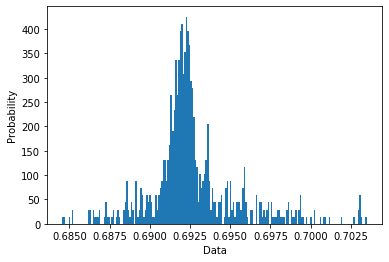

In [76]:
np.random.seed(42)
x = np.random.normal(size=1000)
plt.hist(losses, density=True, bins=200)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [77]:
shapiro_test = stats.shapiro(losses)
print(shapiro_test.statistic)
print(shapiro_test.pvalue)

0.9027544260025024
5.552284667977758e-21


In [129]:




'''def incremental_stats(x):

    global K, Elements, Ex, Ex2
    if Elements == 0:
        K = x
    Elements += 1
    Ex += x - K
    Ex2 += (x - K) * (x - K)

    if (Elements>1):
        mean = K + Ex / Elements
        variance = (Ex2 - (Ex * Ex) / Elements) / (Elements - 1)

        return mean, variance

    return x, 0'''

inc_stats = Incremental_Stats()

print(inc_stats.add(2))
print(inc_stats.add(4))
print(inc_stats.add(6))
print(inc_stats.add(8))
print(inc_stats.add(10))

inc_stats = Incremental_Stats()
print(inc_stats.add(2))
print(inc_stats.add(4))

a = [2,4,6,8,10]
np.std(a, ddof=1)


(2, 0, 0)
(3.0, 2.0, 1.4142135623730951)
(4.0, 4.0, 2.0)
(5.0, 6.666666666666667, 2.581988897471611)
(6.0, 10.0, 3.1622776601683795)
(2, 0, 0)
(3.0, 2.0, 1.4142135623730951)


3.1622776601683795

In [317]:
regenerate = net(torch.from_numpy(real.reshape(1,-1).astype(np.float32))).cpu().detach().numpy().reshape(-1,1)

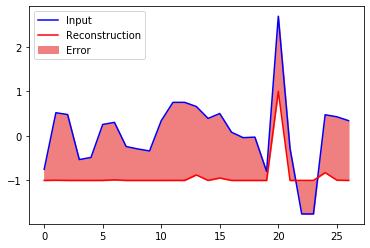

In [318]:
plt.plot(real, 'b')
plt.plot(regenerate, 'r')
plt.fill_between(np.arange(27), regenerate.reshape(1,-1)[0], real.reshape(1,-1)[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [287]:
erros = (regenerate.reshape(1,-1)[0] - real.reshape(1,-1)[0])**2

In [288]:
sum(erros)

0.9406610680591991

## PHASE 2

In [326]:
log = None
y_hat_n2, phi = test(X_train[:1000], X_test, net, loss_function)

Losses X_TRAIN
mu:  0.44753674
std:  0.20366928
phi:  0.651206
******************************
******************************
******************************
Losses X_TEST
mu:  1.0
std:  0.0
phi:  1.0
******************************
******************************
******************************
Losses NORMAL 2
mu:  1.0
std:  0.0
phi:  1.0
******************************
******************************
******************************
Losses F1
mu:  1.0
std:  0.0
phi:  1.0
******************************
******************************
******************************
Losses F2
mu:  1.0
std:  0.0
phi:  1.0
******************************
******************************
******************************
Losses F3
mu:  1.0
std:  0.0
phi:  1.0
******************************
******************************
******************************
Losses F4
mu:  1.0
std:  0.0
phi:  1.0
******************************
******************************
******************************
NORMAL 2
[[0.99833333 0.00166667]
 [0.    

In [329]:
y_hat_n2 = np.array(X_train[:1000])

In [330]:
eq0 = np.where(y_hat_n2 == 0)[0] #ok
eq1 = np.where(y_hat_n2 == 1)[0] #incorrect

print('ok', len(eq0)/len(X_train[:1000]), '%')
print('incorrect', len(eq1)/len(X_train[:1000]), '%')

ok 0.0 %
incorrect 0.0 %


In [10]:
log = open(path+'/output_retrain.txt', "a", buffering=1)

X_train, X_test, y_train, y_test = train_test_split(data_ds3_t2_normal[eq1, :-1], data_ds3_t2_normal[eq1, :-1], test_size=0.2, random_state=42)

architectures = [[dimension,128,9]]
last_layers = [nn.Sigmoid()]
batch_sizes = [32]
optims = ['ADAM']
losses_fnc = [nn.BCEWithLogitsLoss()]

for architecture in architectures:
    for optim in optims:
        for batch_size in batch_sizes:
            for last_layer in last_layers:
                for loss_fnc in losses_fnc:

                    #BCE só SIGMOID
                    if (type(loss_fnc) == type(nn.BCELoss()) and
                            type(last_layer) != type(nn.Sigmoid())):
                        continue

                    print('*****************************************', file=log)
                    print('****************************************', file=log)
                    print('************ HYPERPARAMETERS ************', file=log)
                    print('*****************************************', file=log)
                    print('*****************************************', file=log)
                    print(architecture, file=log)
                    print(last_layer, file=log)
                    print(batch_size, file=log)
                    print(optim, file=log)
                    print(loss_fnc, file=log)
                    print('*****************************************', file=log)
                    print('*****************************************', file=log)

                    net, output, loss, losses, loss_function = train(layers=architecture.copy(), last_layer=last_layer, lr=1e-3, epochs=1, batch_size=batch_size, X_train=X_train, optim=optim, loss_fnc=loss_fnc, net=net)

                    _, phi = test(np.concatenate((X_train, data_ds3_t1_normal[:,:-1])), data_ds3_t1_normal, net, loss_function)

log.close()

epoch [1/1], loss:0.6985


In [80]:
log = open(path+'/output_retrain.txt', "a", buffering=1)
_, phi = test(X_train, data_ds3_t1_normal, net, loss_function) #x_train, x_test, net, loss_fnc ### X_TRAIN precisa conter os dados históricos
log.close()

In [21]:
cf, losses, ground_truth, y_hat = tester({'normal_1': data_ds3_t2_normal}, net, loss_function, loss_threshold = .6919097)

y_hat = np.array(y_hat)

eq0 = np.where(y_hat == 0)[0] #ok
eq1 = np.where(y_hat == 1)[0] #incorrect

print('normal', len(eq0)/len(y_hat), '%')
print('anomaly', len(eq1)/len(y_hat), '%')

normal 0.9122222222222223 %
anomaly 0.08777777777777777 %
